# Lab 2 - Second maze






In [24]:
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(
    precision=3,
    suppress=True,
)  # (not mandatory) This line is for limiting floats to 3 decimal places, avoiding scientific notation (like 1.23e-04) for small numbers.

# For reproducibility
rng = np.random.default_rng(seed=42)  # This line creates a random number generator.

## 2. Maze definition and MDP formulation


### 2.1 Define the maze 

In [25]:
maze_str = [
    "############",
    "#S#.......X#",
    "#.#.###.#.##",
    "#.....#X#..#",
    "#.###.####.#",
    "#...#X#X...#",
    "###.######X#",
    "#.....X...##",
    "#.###.#.#..#",
    "#...#...X#.#",
    "#X#.X#X##G.#",
    "############",
]

In [26]:
n_rows = len(maze_str)
n_cols = len(maze_str[0])

figsize = (n_cols / 2 if n_cols > n_rows else 8, n_rows / 2 if n_rows > n_cols else 8)

### 2.2 Map each walkable cell (not a wall '#') to a state index


In [27]:
FREE = {
    ".",
    "S",
    "G",
    "X",
}  # The vector Free represents cells that the agent is allowed to move into.

**Dictionaries to convert between grid and state index**

In [28]:
state_to_pos = {}  # s -> (i,j)
pos_to_state = {}  # (i,j) -> s

start_state = None  # will store the state index of start state
goal_states = []  # will store the state index of goal state # We use a list in case there are multiple goals
trap_states = []  # will store the state index of trap state # We use a list in case there are multiple traps

s = 0
for i in range(n_rows):  # i = row index
    for j in range(n_cols):  # j = column index
        cell = maze_str[i][j]  # cell = the character at that position (S, ., #, etc.)

        if (
            cell in FREE
        ):  # FREE contains: free cells ".", start cell "S", goal cell "G" and trap cell "X"
            # Walls # are ignored, they are not MDP states.
            state_to_pos[s] = (i, j)
            pos_to_state[(i, j)] = s

            if cell == "S":
                start_state = s
            elif cell == "G":
                goal_states.append(s)
            elif cell == "X":
                trap_states.append(s)

            s += 1

n_states = s

print("Number of states (non-wall cells):", n_states)
print("Start state:", start_state, "at", state_to_pos[start_state])
print("Goal states:", goal_states, "at", state_to_pos[goal_states[0]])
print("Trap states:", trap_states, "at", state_to_pos[trap_states[0]])

Number of states (non-wall cells): 62
Start state: 0 at (1, 1)
Goal states: [60] at (10, 9)
Trap states: [8, 18, 27, 28, 33, 39, 54, 56, 58, 59] at (1, 10)


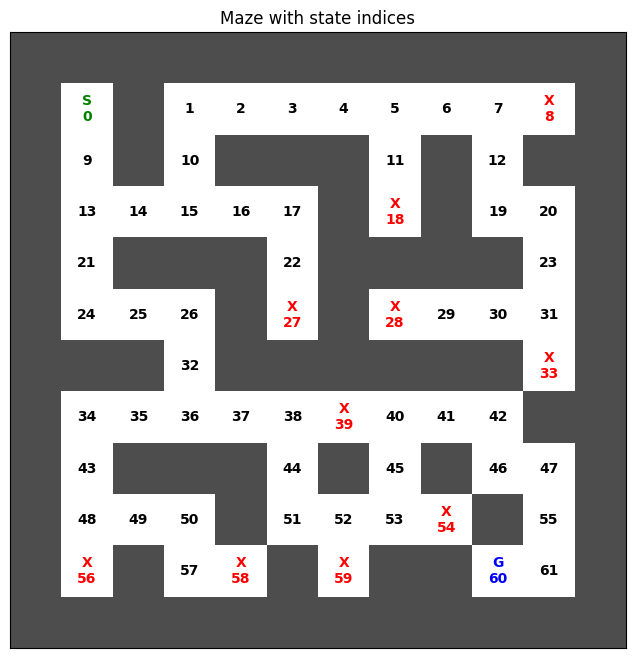

In [29]:
def plot_maze_with_states() -> None:
    """Plot the maze with state indices."""
    grid = np.ones(
        (n_rows, n_cols),
    )  # Start with a matrix of ones. Here 1 means “free cell”
    for i in range(n_rows):
        for j in range(n_cols):
            if maze_str[i][j] == "#":
                grid[i, j] = 0  # We replace walls (#) with 0

    _fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(grid, cmap="gray", alpha=0.7)

    # Plot state indices
    for (
        s,
        (i, j),
    ) in state_to_pos.items():  # Calling .items() returns a list-like sequence of (key, value) pairs in the dictionary.
        cell = maze_str[i][j]

        if cell == "S":
            label = f"S\n{s}"
            color = "green"
        elif cell == "G":
            label = f"G\n{s}"
            color = "blue"
        elif cell == "X":
            label = f"X\n{s}"
            color = "red"
        else:
            label = str(s)
            color = "black"

        ax.text(
            j,
            i,
            label,  # Attention : matplotlib, text(x, y, ...) expects (column, row)
            ha="center",
            va="center",
            fontsize=10,
            fontweight="bold",
            color=color,
        )

    ax.set_xticks([])  # remove numeric axes, we don't need.
    ax.set_yticks([])
    ax.set_title("Maze with state indices")

    plt.show()


plot_maze_with_states()

### 2.4 Actions and deterministic movement

In [30]:
A_UP, A_RIGHT, A_DOWN, A_LEFT = 0, 1, 2, 3
ACTIONS = [A_UP, A_RIGHT, A_DOWN, A_LEFT]
action_names = {A_UP: "\u2191", A_RIGHT: "\u2192", A_DOWN: "\u2193", A_LEFT: "\u2190"}

In [31]:
def move_deterministic(i: int, j: int, a: int) -> tuple[int, int]:
    """Deterministic movement on the grid. If the movement hits a wall or boundary, the agent stays in place.

    Args:
        i (int): current row index
        j (int): current column index
        a (int): action to take (A_UP, A_DOWN, A_LEFT, A_RIGHT)

    Returns:
        (tuple[int, int]): new (row, column) position after taking action a

    """
    candidate_i, candidate_j = (
        i,
        j,
    )  # It means “Unless the action succeeds, the robot stays in place.”

    # Now each action changes the coordinates of the robot:
    if a == A_UP:
        candidate_i, candidate_j = (
            i - 1,
            j,
        )  # if the action is UP, then row becomes row -1
    elif a == A_DOWN:
        candidate_i, candidate_j = (
            i + 1,
            j,
        )  # if the action is DOWN, then row becomes row +1
    elif a == A_LEFT:
        candidate_i, candidate_j = (
            i,
            j - 1,
        )  # if the action is LEFT, then column becomes column -1
    elif a == A_RIGHT:
        candidate_i, candidate_j = (
            i,
            j + 1,
        )  # if the action is RIGHT, then column becomes column +1

    # Check boundaries
    if not (0 <= candidate_i < n_rows and 0 <= candidate_j < n_cols):
        # If the robot tries to move outside the maze
        # It will not move and it stays at (i, j).
        return i, j

    # Check wall
    if maze_str[candidate_i][candidate_j] == "#":
        # If the next cell is a wall, the robot stays in place.
        return i, j

    return candidate_i, candidate_j  # Otherwise, return the new position

### 2.5 Transition probabilities and reward function

In [32]:
gamma = 0.95
p_error = 0.1  # probability of the error to a random other direction

In [33]:
# Initialize transition matrices and reward vector
P = np.zeros((len(ACTIONS), n_states, n_states))
R = np.zeros(n_states)

In [34]:
# Set rewards for each state
step_penalty = -0.01
goal_reward = 1.0
trap_reward = -1.0

In [35]:
for s in range(n_states):
    if s in goal_states:
        R[s] = goal_reward
    elif s in trap_states:
        R[s] = trap_reward
    else:
        R[s] = step_penalty

In [36]:
terminal_states = set(goal_states + trap_states)


def is_terminal(s: int) -> bool:
    """Check if a state is terminal (goal or trap)."""
    return s in terminal_states

In [37]:
for s in range(n_states):  # We loop over all states s.
    i, j = state_to_pos[
        s
    ]  # We recover the states to their coordinates (i, j) in the maze.

    # First, in a goal or trap state,
    # No matter which action you “choose”, you stay in the same state with probability 1.
    # This makes the terminal states as the absorbing states.
    if is_terminal(s):
        # Terminal states: stay forever
        for a in ACTIONS:
            P[a, s, s] = goal_reward
        continue

    # If the state is non-terminal, we define the stochastic movement.
    # For a given state s and intended action a,
    # With probability 1 - p_error, the robot will move in direction a;
    # With probability p_error, the robot will move in one of the other 3 directions, each with probability p_error / 3.
    for a in ACTIONS:
        # main action (intended action)
        main_i, main_j = move_deterministic(i, j, a)
        s_main = pos_to_state[
            (main_i, main_j)
        ]  # s_main is the state index of that next cell.
        P[a, s, s_main] += (
            1 - p_error
        )  # We add probability 1 - p_error to P[a, s, s_main].

        # error actions
        other_actions = [
            a2 for a2 in ACTIONS if a2 != a
        ]  # other_actions = the 3 actions different from a.
        for a2 in other_actions:  # for each of the error action,
            error_i, error_j = move_deterministic(i, j, a2)
            s_error = pos_to_state[(error_i, error_j)]  # get its state index s_error
            P[a, s, s_error] += p_error / len(
                other_actions,
            )  # add p_error / 3 to P[a, s, s_error]
# So for each (s,a), probabilities over all s_next sum to 1.

In [38]:
for a in ACTIONS:
    # For each action a:
    # P[a] is a matrix of shape (n_states, n_states).
    # P[a].sum(axis=1) sums over next states s_next, giving for each state s:
    # We print these row sums.
    # If everything is correct, they should be very close to 1.

    probs = P[a].sum(axis=1)
    print(f"Action {action_names[a]}:", probs)

Action ↑: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Action →: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Action ↓: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Action ←: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## 3. Policy evaluation

### 3.1 Bellman expectation equation

In [39]:
def policy_evaluation(  # noqa: PLR0913
    policy: np.ndarray,
    P: np.ndarray,
    R: np.ndarray,
    gamma: float,
    theta: float = 1e-6,
    max_iter: int = 10_000,
) -> np.ndarray:
    """Evaluate a deterministic policy for the given MDP.

    Args:
        policy: array of shape (n_states,), with values in {0,1,2,3}
        P: array of shape (n_actions, n_states, n_states)
        R: array of shape (n_states,)
        gamma: discount factor
        theta: convergence threshold
        max_iter: maximum number of iterations

    """
    n_states = len(R)  # get the number of states
    V = np.zeros(n_states)  # initialize the value function

    for _it in range(max_iter):  # Main iterative loop
        V_new = np.zeros_like(
            V,
        )  # Create a new value vector and we will compute an updated value for each state.

        # Now we update each state using the Bellman expectation equation
        for s in range(n_states):
            a = policy[s]  # Extract the action chosen by the policy in state
            V_new[s] = R[s] + gamma * np.sum(P[a, s, :] * V)

        delta = np.max(
            np.abs(V_new - V),
        )  # This measures how much the value function changed in this iteration:
        # If delta is small, the values start to converge; otherwise, we need to keep iterating.
        V = V_new  # Update V, i.e. Set the new values for the next iteration.

        if delta < theta:  # Check convergence: When changes are tiny, we stop.
            break

    return V  # Return the final value function, this is our estimate for V^{pi}(s), s in the state set.

In [40]:
def plot_values(V: np.ndarray, title="Value function") -> None:
    """Plot the value function V on the maze as a heatmap."""
    grid_values = np.full(
        (n_rows, n_cols),
        np.nan,
    )  # Initializes a grid the same size as the maze. Every cell starts as NaN.
    for (
        s,
        (i, j),
    ) in (
        state_to_pos.items()
    ):  # recall that state_to_pos maps each state index to its maze coordinates (i,j).
        grid_values[i, j] = V[
            s
        ]  # For each reachable cell, we write the value V[s] in the grid.
        # Walls # never get values, and they stay as NaN.

    _fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(grid_values, cmap="magma")
    plt.colorbar(im, ax=ax)

    # For each state:
    # Place the text label at (column j, row i).
    # Display value to two decimals.
    # Use white text so it’s visible on the heatmap.
    # Center the text inside each cell.

    for s, (i, j) in state_to_pos.items():
        ax.text(
            j,
            i,
            f"{V[s]:.2f}",
            ha="center",
            va="center",
            color="white",
            fontsize=9,
        )

    # Remove axis ticks and set title
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    plt.show()

In [ ]:
def plot_policy(policy: np.ndarray, title="Policy") -> None:
    """Plot the given policy on the maze."""
    _fig, ax = plt.subplots(figsize=figsize)
    # draw walls as dark cells
    wall_grid = np.zeros((n_rows, n_cols))
    for i in range(n_rows):
        for j in range(n_cols):
            if maze_str[i][j] == "#":
                wall_grid[i, j] = 1
    ax.imshow(wall_grid, cmap="Greys", alpha=0.5)

    for s, (i, j) in state_to_pos.items():
        cell = maze_str[i][j]
        if cell == "#":
            continue

        if s in goal_states:
            ax.text(
                j,
                i,
                "G",
                ha="center",
                va="center",
                fontsize=14,
                fontweight="bold",
                color="blue",
            )
        elif s in trap_states:
            ax.text(
                j,
                i,
                "X",
                ha="center",
                va="center",
                fontsize=14,
                fontweight="bold",
                color="red",
            )
        elif s == start_state:
            ax.text(
                j,
                i,
                "S",
                ha="center",
                va="center",
                fontsize=14,
                fontweight="bold",
                color="green",
            )
        else:
            a = policy[s]
            ax.text(
                j,
                i,
                action_names[a],
                ha="center",
                va="center",
                fontsize=14,
                color="black",
            )

    ax.set_xticks(np.arange(-0.5, n_cols, 1))
    ax.set_yticks(np.arange(-0.5, n_rows, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(visible=True)
    ax.set_title(title)
    plt.show()

### 3.3 Evaluating a policy

In [42]:
# Random policy: for each state, pick a random action
random_policy = rng.integers(low=0, high=len(ACTIONS), size=n_states)

print(random_policy)

[0 3 2 1 1 3 0 2 0 0 2 3 2 3 2 3 2 0 3 1 2 1 0 3 3 2 1 3 2 1 1 0 0 2 3 0 3
 3 1 2 0 3 2 1 0 3 1 3 2 3 3 0 1 1 1 0 2 0 2 2 3 2]


In [43]:
V_random = policy_evaluation(policy=random_policy, P=P, R=R, gamma=gamma)
print("Value function under random policy:")
print(V_random)

Value function under random policy:
[ -0.2    -0.295  -0.534  -1.301  -1.394  -1.467  -0.827  -1.176 -20.
  -0.2    -0.207  -6.086  -0.548  -0.2    -0.201  -0.204  -0.28   -0.481
 -20.     -0.546  -0.566  -0.2    -1.126  -0.588  -0.201  -0.203  -0.209
 -20.    -20.     -1.769  -1.186  -1.222  -0.229 -20.     -1.944  -0.862
  -0.824  -1.381 -18.279 -20.     -7.557  -6.924  -0.44   -5.78  -17.248
  -7.364  -0.214  -0.207 -18.427 -17.386 -16.41  -16.347 -17.519 -18.483
 -20.     -0.013 -20.    -15.666 -20.    -20.     20.      5.496]


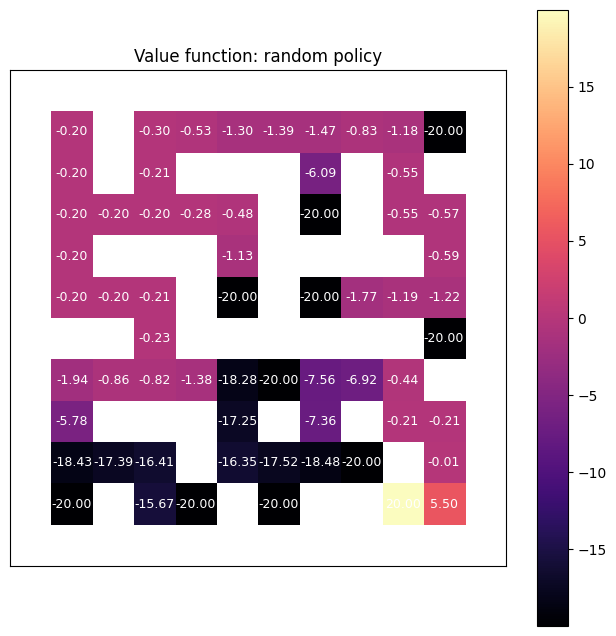

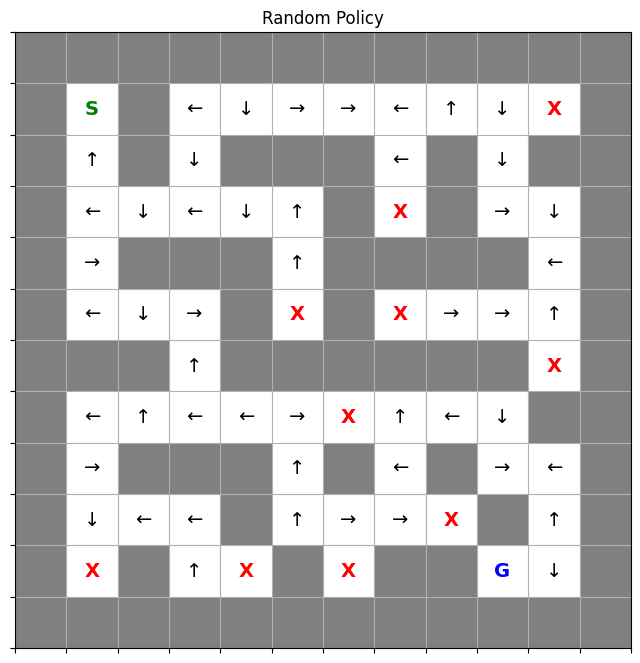

In [44]:
plot_values(V_random, title="Value function: random policy")
plot_policy(policy=random_policy, title="Random Policy")

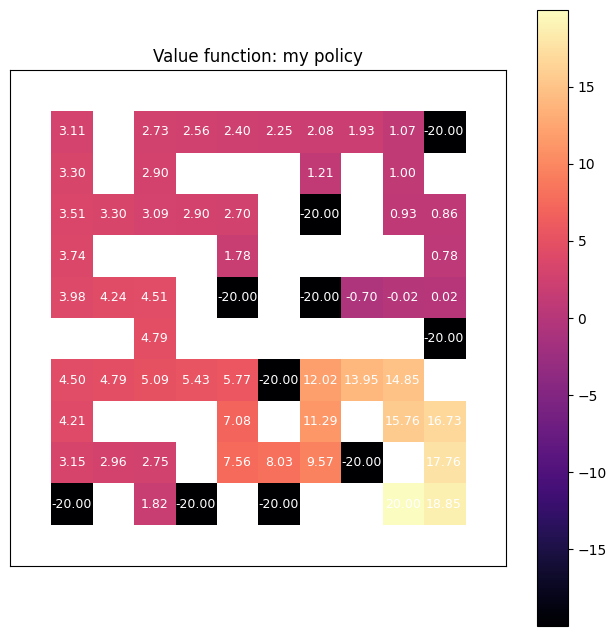

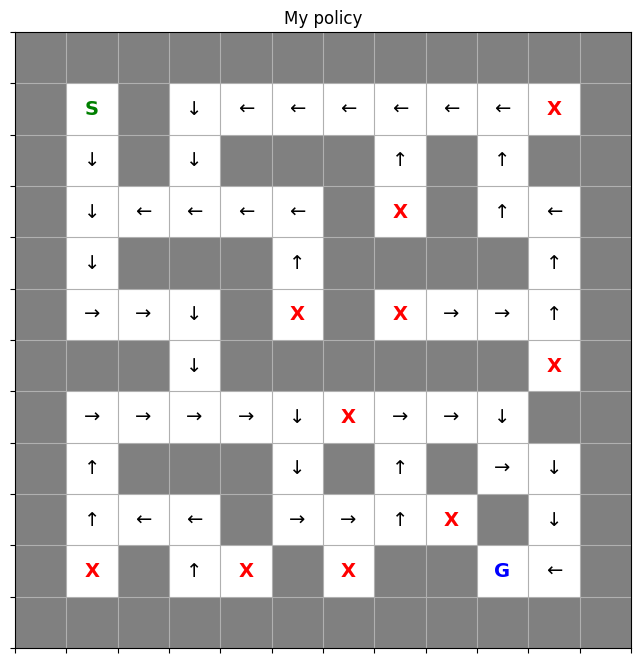

In [45]:
my_policy = np.array([
    A_DOWN,
    A_DOWN,
    A_LEFT,
    A_LEFT,
    A_LEFT,
    A_LEFT,
    A_LEFT,
    A_LEFT,
    A_LEFT,
    A_DOWN,
    A_DOWN,
    A_UP,
    A_UP,
    A_DOWN,
    A_LEFT,
    A_LEFT,
    A_LEFT,
    A_LEFT,
    A_UP,
    A_UP,
    A_LEFT,
    A_DOWN,
    A_UP,
    A_UP,
    A_RIGHT,
    A_RIGHT,
    A_DOWN,
    A_UP,
    A_RIGHT,
    A_RIGHT,
    A_RIGHT,
    A_UP,
    A_DOWN,
    A_UP,
    A_RIGHT,
    A_RIGHT,
    A_RIGHT,
    A_RIGHT,
    A_DOWN,
    A_RIGHT,
    A_RIGHT,
    A_RIGHT,
    A_DOWN,
    A_UP,
    A_DOWN,
    A_UP,
    A_RIGHT,
    A_DOWN,
    A_UP,
    A_LEFT,
    A_LEFT,
    A_RIGHT,
    A_RIGHT,
    A_UP,
    A_LEFT,
    A_DOWN,
    A_UP,
    A_UP,
    A_LEFT,
    A_UP,
    A_DOWN,
    A_LEFT,
])

V_my_policy = policy_evaluation(policy=my_policy, P=P, R=R, gamma=gamma)

plot_values(V=V_my_policy, title="Value function: my policy")
plot_policy(policy=my_policy, title="My policy")